## Vector quantization

Most vector embeddings are stored as floating point numbers (64-bit in Python). We can use **quantization** to reduce the size of the embeddings.

In [2]:
# Load in the vectors from movies.json, {movie: [vector]}
import json

with open('embeddings/movies_text-embedding-3-small-1536.json') as f:
    movies = json.load(f)

movies['The Little Mermaid'][0:10]

[-0.0039056178648024797,
 0.019039113074541092,
 0.004666934721171856,
 0.003809679765254259,
 -0.012193450704216957,
 -0.02396601065993309,
 -0.028496775776147842,
 0.02036368101835251,
 -0.04020743817090988,
 -0.0006201174110174179]

## Scalar quantization


In [3]:
def scalar_quantization(embeddings: list[list[float]], num_levels=256, min_level=-128, max_level=127):
    # Flatten the embeddings to find the global min and max
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    min_val = min(flattened_embeddings)
    max_val = max(flattened_embeddings)
    
    # Normalize the embeddings to [0, 1]
    normalized_embeddings = [
        [(number - min_val) / (max_val - min_val) for number in embedding]
        for embedding in embeddings
    ]
    
    # Quantize the normalized values to the specified number of levels
    quantized_embeddings = [
        [int(round(number * (num_levels - 1)) * (max_level - min_level) / (num_levels - 1) + min_level)
        for number in embedding]
        for embedding in normalized_embeddings
    ]
    
    return quantized_embeddings

quantized_embeddings = scalar_quantization(list(movies.values()))
movies_1byte = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), quantized_embeddings)
}

# Check the first 10 bytes of the quantized vector for 'Moana'
print(movies_1byte['The Little Mermaid'][0:10])

[29, 44, 35, 34, 24, 16, 13, 45, 6, 31]


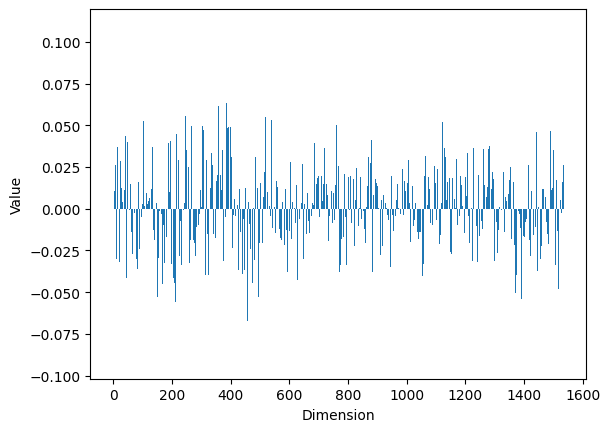

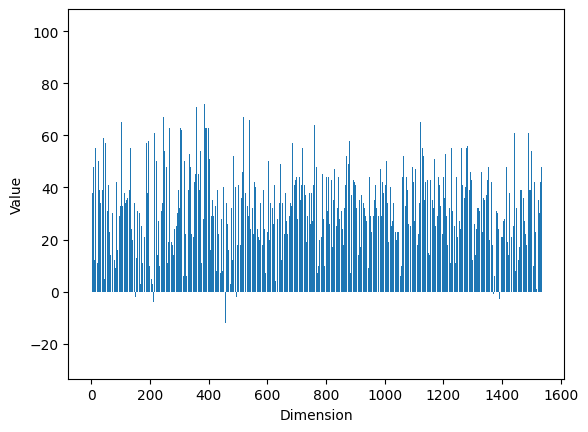

In [4]:
import matplotlib.pyplot as plt


def render_vector(vector):
    """Visualize the values of the vector in a bar chart"""
    plt.bar(range(len(vector)), vector)
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.show()

render_vector(movies['Moana'])
render_vector(movies_1byte['Moana'])

In [5]:
# 10 most similar movies to Moana
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['movie', 'similarity'])
    return df

most_similar('Moana', movies_1byte)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.903532
2,The Little Mermaid,0.894227
3,Lilo & Stitch,0.893718
4,Big Hero 6,0.890959
5,Monsters University,0.890915
6,The Princess and the Frog,0.889009
7,Finding Dory,0.888350
8,Ice Princess,0.885539
9,Maleficent,0.885364


In [6]:
most_similar('Moana', movies)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.546800
2,Lilo & Stitch,0.502114
3,The Little Mermaid,0.498209
4,Big Hero 6,0.491800
5,Monsters University,0.484857
6,The Princess and the Frog,0.471984
7,Finding Dory,0.471386
8,Maleficent,0.461029
9,Ice Princess,0.457817


## Binary quantization

The most extreme form of quantization is to store the embeddings as binary numbers, setting each dimension to 0 or 1, based on a threshold.

In [7]:
def binary_quantization(embeddings):
    """Turn a float32 into a bit based off provided threshold"""
    
    # find mean of all the dimensions
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    mean_val = sum(flattened_embeddings) / len(flattened_embeddings)
    
    # quantize the embeddings to 1 bit
    quantized_embeddings = [
        [1 if number > mean_val else 0 for number in embedding]
        for embedding in embeddings
    ]
    return quantized_embeddings

binary_quantized_embeddings = binary_quantization(list(movies.values()))
movies_1bit = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), binary_quantized_embeddings)
}

# Check the first 10 bits of the quantized vector for 'Moana'
print(movies_1bit['Moana'][0:10])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


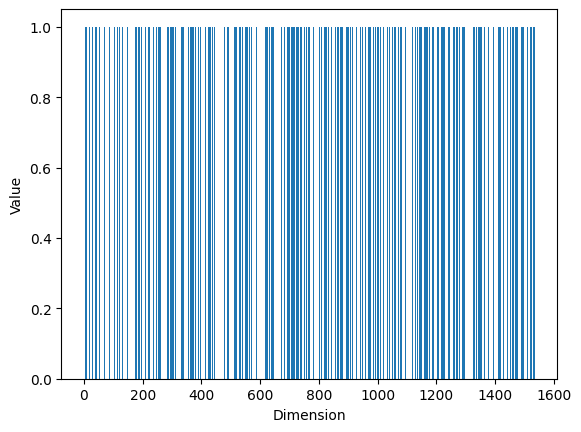

In [8]:
render_vector(movies_1bit['Moana'])

In [9]:
most_similar('Moana', movies_1bit)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.686634
2,The Little Mermaid,0.666260
3,The Princess and the Frog,0.659825
4,Lilo & Stitch,0.657599
5,Big Hero 6,0.655869
6,Ice Princess,0.648046
7,Finding Dory,0.643830
8,The Lion King,0.643088
9,Maleficent,0.642270


## Size comparison

In [10]:
import sys

pd.DataFrame({
    'float64': [sys.getsizeof(movies['Moana'])],
    'int8': [sys.getsizeof(movies_1byte['Moana'])],
    'int1': [sys.getsizeof(movies_1bit['Moana'])],
})

,float64,int8,int1
0,12728,12728,12728


In [11]:
# Now convert each to numpy arrays of the appropriate type
import numpy as np
def convert_to_numpy(movies, dtype):
    return {
        movie: np.array(embedding, dtype=dtype)
        for movie, embedding in movies.items()
    }
movies_float64 = convert_to_numpy(movies, np.float64)
movies_int8 = convert_to_numpy(movies_1byte, np.int8)
movies_int1 = convert_to_numpy(movies_1bit, np.int8)

pd.DataFrame({
    'float64': [sys.getsizeof(movies_float64['Moana'])],
    'int8': [sys.getsizeof(movies_int8['Moana'])],
    'int1': [sys.getsizeof(movies_int1['Moana'])],
})

,float64,int8,int1
0,12400,1648,1648


In [12]:
sys.getsizeof(movies_float64['Moana'])/sys.getsizeof(movies_int8['Moana'])

7.524271844660194

## Resources

* [Scalar quantization 101](https://www.elastic.co/search-labs/blog/scalar-quantization-101)
* [Product quantization 101](https://www.pinecone.io/learn/series/faiss/product-quantization/)
* [Binary and scalar quantization](https://huggingface.co/blog/embedding-quantization)